<a href="https://colab.research.google.com/github/tyui592/Real_Time_Helmet_Detection/blob/master/RealTimeHelmetDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set up the environment
### Don't forget to change the runtime type to GPU if using google colab

**Author**: `Minseong Kim`(tyui592@gmail.com)

In [1]:
# download src code
!git clone https://github.com/tyui592/Real_Time_Helmet_Detection

# download argments to make model
!gdown https://drive.google.com/uc?id=1jDR9kAZ7Ch0wzbcUJhdlbbpzViwjegGo

# download model weight
!gdown https://drive.google.com/uc?id=1eli7-y_Dnfn-X2GD39gXDMI8Xl2PBW37

fatal: destination path 'Real_Time_Helmet_Detection' already exists and is not an empty directory.
Downloading...
From: https://drive.google.com/uc?id=1jDR9kAZ7Ch0wzbcUJhdlbbpzViwjegGo
To: /content/argument.pickle
100% 1.04k/1.04k [00:00<00:00, 1.67MB/s]
Downloading...
From: https://drive.google.com/uc?id=1eli7-y_Dnfn-X2GD39gXDMI8Xl2PBW37
To: /content/check_point.pth
61.3MB [00:00, 132MB/s] 


In [2]:
import argparse
import torch
device = torch.device('cuda')
import sys
sys.path.append('./Real_Time_Helmet_Detection')

from utils import imload, draw_box
from train import load_network
from evaluate import Prediction
from data import INDEX2CLASS, CLASS2COLOR 

In [3]:
# install pickle5
!pip install pickle5
import pickle5
with open('argument.pickle', 'rb') as f:
    args = pickle5.load(f)

In [4]:
!ls

argument.pickle  check_point.pth  Real_Time_Helmet_Detection  sample_data


In [5]:
args.model_load = './check_point.pth'
args.imsize = 512
args.save_path = './'
args.data = './Real_Time_Helmet_Detection/imgs/000019.jpg'
args.topk = 100
args.conf_th = 0.2
args.nms_th = 0.2
args.fontsize = 0

In [6]:
detector, _, _, _ = load_network(args, device)

Fri Oct  9 06:58:53 2020: Weights are loaded from ./check_point.pth


In [7]:
predictor = Prediction(network = detector,
                       topk = args.topk,
                       scale_factor = args.scale_factor,
                       conf_th = args.conf_th,
                       nms = args.nms,
                       nms_th = args.nms_th,
                       normalized_coord=False).to(device)
predictor.eval()

Prediction(
  (network): StackedHourglass(
    (pre_layer): PreLayer(
      (layers): Sequential(
        (0): Convolution(
          (activation): Activation(
            (activation): ReLU()
          )
          (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): Residual(
          (activation): Activation(
            (activation): ReLU()
          )
          (conv1): Convolution(
            (activation): Activation(
              (activation): ReLU()
            )
            (convolution): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (conv2): Convolution(
            (activation): Activation(
              (activation): Identity()
            )
            (convolution): Conv2d(12

In [8]:
img_ten, img_pil, origin_size = imload(args.data, args.pretrained, args.imsize)

In [9]:
box_ten, cls_ten, score_ten = predictor(img_ten.to(device))
box_lst, cls_lst, score_lst = box_ten[0].tolist(), cls_ten[0].tolist(), score_ten[0].tolist()

Index:   0, Class:     hat, Score: 0.88, Box:  644,   43,  709,  159
Index:   1, Class:     hat, Score: 0.86, Box:   45,   63,   69,  124
Index:   2, Class:     hat, Score: 0.85, Box:  421,  125,  470,  242
Index:   3, Class:     hat, Score: 0.83, Box:  122,   69,  142,  125
Index:   4, Class:  person, Score: 0.80, Box:  283,   70,  296,  115
Index:   5, Class:     hat, Score: 0.80, Box:  506,   68,  523,  116
Index:   6, Class:     hat, Score: 0.79, Box:  428,   72,  443,  122
Index:   7, Class:  person, Score: 0.75, Box:  244,   73,  257,  118
Index:   8, Class:     hat, Score: 0.75, Box:  139,   66,  159,  121
Index:   9, Class:     hat, Score: 0.74, Box:  528,   64,  543,  110
Index:  10, Class:     hat, Score: 0.74, Box:   99,   63,  121,  121
Index:  11, Class:     hat, Score: 0.73, Box:  583,   73,  596,  121
Index:  12, Class:  person, Score: 0.73, Box:  368,   72,  382,  120
Index:  13, Class:  person, Score: 0.73, Box:  261,   75,  273,  120
Index:  14, Class:     hat, Score:

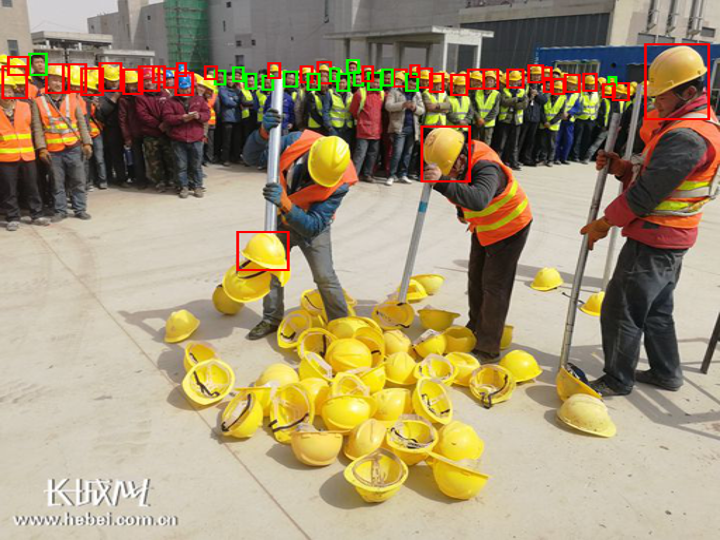

In [10]:
# clamp outside image
box_lst = [list(map(lambda x: max(0, min(x, args.imsize)), box)) for box in box_lst]

# draw box, class and score per prediction
for i, (box, cls, score) in enumerate(zip(box_lst, cls_lst, score_lst)):
    img_pil = draw_box(img_pil, box, color=CLASS2COLOR[cls])

    # resize origin scale of image
    xmin, ymin, xmax, ymax = box
    xmin = xmin*origin_size[0]/args.imsize
    ymin = ymin*origin_size[1]/args.imsize
    xmax = xmax*origin_size[0]/args.imsize
    ymax = ymax*origin_size[0]/args.imsize

    print('Index: %3d, Class: %7s, Score: %1.2f, Box: %4d, %4d, %4d, %4d'%(i, INDEX2CLASS[cls], score, xmin, ymin, xmax, ymax))

# resize to origin size and save the result image
img_pil.resize(origin_size)